In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

plt.style.use('ggplot')

In [2]:
working_dir = '/scratch/msc24h18/msc_project'
rel_path = 'data/LBE247_analyzed/LBE247_ID301XR1000Oct/pulsedAmplitudeSweep_DCIV_20240919143913/pulsedAmplitudeSweep_DCIV[LBE247_ID301XR1000Oct(1)]20240919144143/pulsedAmplitudeSweep_DCIV[LBE247_ID301XR1000Oct(1)]20240919144143_Summary.dat'

data = pd.read_csv(os.path.join(working_dir, rel_path), skiprows=6)

data.head()

,Pulse Number,index,Pulse Amplitude (V),R_low (ohm),R_high (ohm)
0,1,2,0.2,4.618938e+09,5.227392e+09
1,2,3,0.3,4.649000e+09,5.279831e+09
2,3,4,0.4,4.814636e+09,5.482456e+09
3,4,5,0.5,5.157298e+09,5.889282e+09
4,5,6,0.6,5.707763e+09,6.480881e+09


Number of LTP pulses: 22
Number of LTD pulses: 24


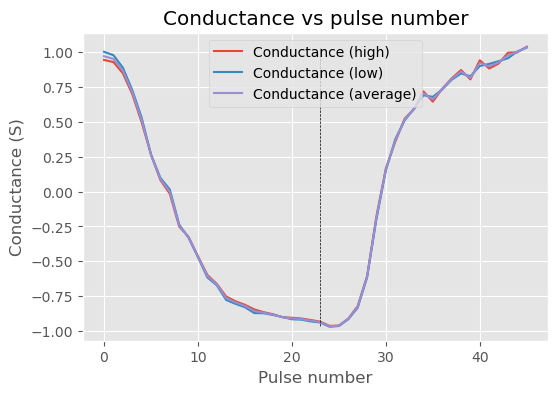

In [3]:
conductance_l = np.array(1 / data['R_high (ohm)'])
conductance_h = np.array(1 / data['R_low (ohm)'])
conductance = (conductance_l + conductance_h) / 2

def normalize(c):
    return 2 * (c - c.mean()) / (c.max() - c.min())

conductance_l = normalize(conductance_l)
conductance_h = normalize(conductance_h)
conductance = normalize(conductance)

pulses = np.array([-1 if v > 0 else 1 for v in data['Pulse Amplitude (V)']]) # ltp pulses are expected to be positive for fitting to work
conductance_ltp = conductance[np.where(pulses == 1)[0]]
conductance_ltd = conductance[np.where(pulses == -1)[0]]
pulse_change_idx = np.where(np.diff(pulses) != 0)[0]

print(f"Number of LTP pulses: {len(conductance_ltp)}")
print(f"Number of LTD pulses: {len(conductance_ltd)}")

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(conductance_h, label='Conductance (high)')
ax.plot(conductance_l, label='Conductance (low)')
ax.plot(conductance, label='Conductance (average)')
ax.vlines(pulse_change_idx, conductance.min(), conductance.max(), color='k', ls='--', lw=0.5)
ax.set(xlabel="Pulse number", ylabel="Conductance (S)", title="Conductance vs pulse number")
ax.legend()
plt.show()

SoftBoundsReferenceDevice(
    dw_min=0.1412128897291387,
    dw_min_dtod=0.0,
    dw_min_std=0.0,
    reset_std=0.0,
    up_down=0.19692749197224857,
    up_down_dtod=0.0,
    w_max=1.324918280482748,
    w_max_dtod=0.0,
    w_min=-1.5997081938073268,
    w_min_dtod=0.0
)


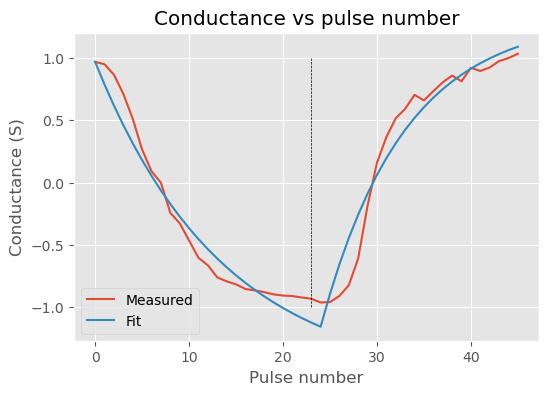

In [4]:
from aihwkit.utils.fitting import fit_measurements
from aihwkit.simulator.configs import SoftBoundsReferenceDevice

params = {'dw_min': (0.1, 0.001, 1.0),
          'up_down': (0.0, -0.99, 0.99),
          'w_max': (1.0, 0.1, 2.0),
          'w_min': (-1.0, -2.0, -0.1),
          }

result, device_config_fit, best_model_fit = fit_measurements(
    params,
    pulses,
    conductance,
    SoftBoundsReferenceDevice())

print(device_config_fit)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(conductance, label='Measured')
ax.plot(best_model_fit, label='Fit')
ax.vlines(pulse_change_idx, -1, 1, color='k', ls='--', lw=0.5)
ax.set(xlabel="Pulse number", ylabel="Conductance (S)", title="Conductance vs pulse number")
ax.legend()
plt.show()

std = (conductance - best_model_fit).std() / device_config_fit.dw_min
write_noise_std = np.sqrt(std ** 2 - device_config_fit.dw_min_std ** 2)/2

SoftBoundsReferenceDevice(
    dw_min=0.1412128897291387,
    dw_min_dtod=0.0,
    dw_min_std=0.0,
    reset_std=0.0,
    up_down=0.19692749197224857,
    up_down_dtod=0.0,
    w_max=1.324918280482748,
    w_max_dtod=0.0,
    w_min=-1.5997081938073268,
    w_min_dtod=0.0
)


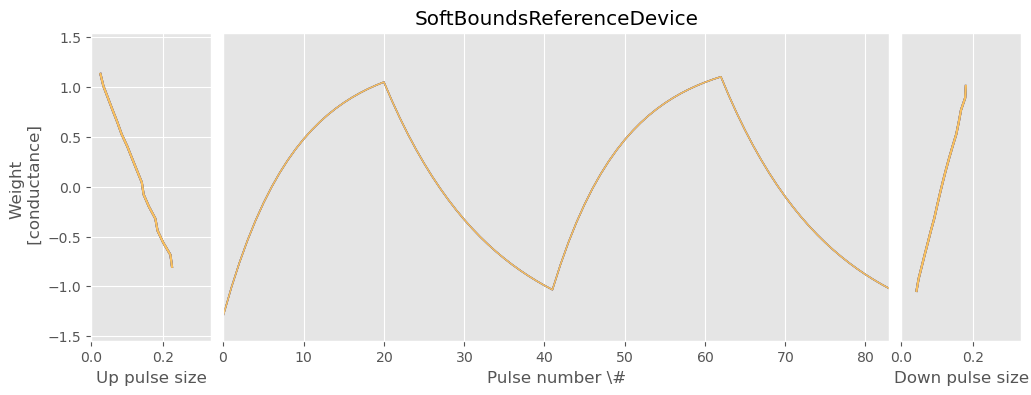

In [5]:
from aihwkit.utils.visualization import plot_device_compact

print(device_config_fit)
plot_device_compact(device_config_fit, n_traces=5);

SoftBoundsReferenceDevice(
    construction_seed=2024,
    dw_min=0.1412128897291387,
    reset_std=0.0,
    up_down=0.19692749197224857,
    w_max=1.324918280482748,
    w_min=-1.5997081938073268,
    write_noise_std=3.7341981889194003,
    reference_std=0.05
)


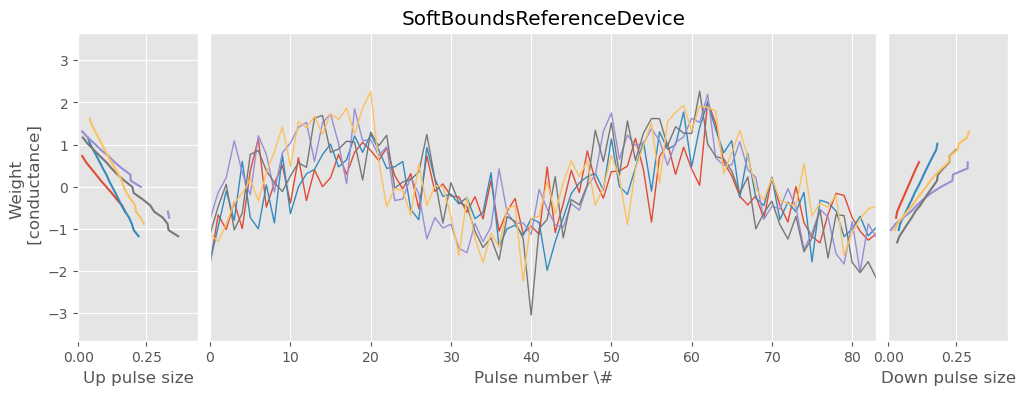

In [8]:
device_config_fit.dw_min_dtod = 0.3
device_config_fit.dw_min_std = 0.3
device_config_fit.w_min_dtod = 0.3
device_config_fit.w_max_dtod = 0.3
device_config_fit.up_down_dtod = 0.01
device_config_fit.write_noise_std = 1 * write_noise_std
device_config_fit.reference_std = 0.05
device_config_fit.enforce_consistency = True
device_config_fit.dw_min_dtod_log_normal = False
device_config_fit.mult_noise = False
device_config_fit.construction_seed = 2024

print(device_config_fit)

plot_device_compact(device_config_fit, n_traces=5);